# Bayesian Statistics for Physicists: 07 Gaussian processes

## Contents of the BSFP series

<ul>
    <li><a href="BSFP_01_Overview_and_setup.ipynb">01 Overview and Setup</a>
    <li><a href="BSFP_02_Basics.ipynb">02 Bayesian basics</a>
    <li><a href="BSFP_03_Choosing_priors.ipynb">03 Choosing priors</a>
    <li><a href="BSFP_04_Bayesian_updating.ipynb">04 Examples of Bayesian updating</a>
    <li><a href="BSFP_05_Sampling.ipynb">05 Sampling</a>
    <li><a href="BSFP_06_Model_selection_and_mixing.ipynb">06 Model selection, mixing, ...</a>
    <li><a href="BSFP_07_Gaussian_processes.ipynb">07 Gaussian processes</a>
    <li><a href="BSFP_08_Machine_learning.ipynb">08 Machine learning</a>
    <li><a href="BSFP_A01_Appendices.ipynb">A01 Appendices: reference, vocabulary, notation</a>
</ul>

<hr>

## <a name="Overview">Overview of 07 Gaussian processes</a>

Last revised: 14-Oct-2018 by Dick Furnstahl [furnstahl.1@osu.edu].

<hr>

## <a name="Contents">Contents of 07 Gaussian processes</a> 

<ul>
    <li><a href="#GPs">Gaussian processes</a> 
</ul>

<hr>

## <a name="Python">Python/Jupyter set up</a>

See <a href="BSFP_01_Overview_and_setup.ipynb">Part 01</a> for overall installation and setup.

In [1]:
# set up for plots in this notebook using matplotlib (there are other plotting choices)
%matplotlib inline   

In [2]:
import numpy as np

import scipy.stats as stats
from scipy.stats import norm, uniform

import matplotlib.pyplot as plt
#plt.style.use('seaborn') # pretty matplotlib plots

import corner
import pymc3 as pm


/Users/furnstah/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# make font adjustments
#plt.rcParams['font.size'] = 12
#plt.rcParams['legend.fontsize'] = 'medium'
#plt.rcParams['figure.titlesize'] = 'medium'
plt.rcdefaults()  # revert to defaults for now

In [4]:
%%html  
<!-- Use html cell magic to add css styling -->
<style>
  em {
      color: red;
  }
  dd {
      margin-left: 15px;
  }
  .red{color: red}
  .blue{color: blue}
</style>

## <a name="GPs">Gaussian processes (GPs)</a> 

### Overview of GPs

GP: the natural generalization of multivariate Gaussian random variables to infinite (countably or continuous) index sets.  They look like random functions, but with characteristic degrees of smoothness, correlation lengths, and range.  Here are some examples with different "kernels" and different parameters that dictate those features (figure from J. Melendez):

<img src="figures/gp_kernel_realizations.png" width="400" >


#### Explanations of GPs from the web

The following is adapted from a blog entry from Kathleen Bailey at http://katbailey.github.io/post/gaussian-processes-for-dummies/.

"Here’s how Kevin Murphy explains it in the excellent textbook <i>Machine Learning: A Probabilistic Perspective</i>:" 
'A GP defines a prior over functions, which can be converted into a posterior over functions once we have seen some data. Although it might seem difficult to represent a distribution over a function, it turns out that we only need to be able to define a distribution over the function’s values at a finite, but arbitrary, set of points, say $x_1, \ldots, x_N$.  A GP assumes that $p(f(x_1),\ldots,f(x_N))$ is jointly Gaussian, with some mean $\mu(x)$ and covariance $\Sigma(x)$ given by $\kappa_{ij} = \Sigma(x_i,x_j)$, where $\kappa$ is a positive definite kernel function. The key idea is that if $x_i$ and $x_j$ are deemed by the kernel to be similar, then we expect the output of the function at those points to be similar, too.'

So it is important to stress that we are really only dealing with a discrete set of points. Thus the physicist-friendly idea of a continuum limit of masses on springs may be preferred to more abstract notions in function space.

It should also be sufficient to consider the bivariate case, because the generalization from one to two variables is really where the new feature of correlation comes in.  Generalizing further really doesn't introduce anything new.

### Bivariate normal case

$\newcommand{\xvec}{\textbf{x}}$
$\newcommand{\muvec}{\boldsymbol{\mu}}$
The general multivariate Gaussian distribution is
$$
 p(\xvec\mid \muvec,\Sigma) = \frac{1}{\sqrt{\det(2\pi\Sigma)}} e^{-\frac12(\xvec-\muvec)^{\rm T}\Sigma^{-1}(\xvec-\muvec)}
$$

For the <em>bivariate</em> case we can parameterize the mean vector and covariance matrix as
$$
  \muvec = \left( \begin{array}{c}
                     \mu_x \\ \mu_y
                  \end{array}       \right)
    \;, \qquad
  \Sigma = \left( \begin{array}{cc}
                    \sigma_x^2 & \rho\sigma_x\sigma_y \\
                    \rho\sigma_x\sigma_y & \sigma_y^2
                  \end{array}
           \right)  
$$
The covariance matrix must be positive definite, which implies $\color{red}{0\lt\rho^2\lt 1}$.

If take $\mu_x = \mu_y = 0$ and $\sigma_x = \sigma_y = \sigma$ for clarity,
so that
$$
  \Sigma = \sigma^2 \left(\begin{array}{cc}
                       1 & \rho \\
                       \rho & 1
                       \end{array}
                    \right)
$$
and
$$
  p(x,y\mid \sigma,\rho) = \frac{1}{2\pi\sigma^2} 
        \exp\left(-\frac{x^2 + y^2 - 2\rho x y }{2\sigma^2\sqrt{1-\rho^2}}    
          \right)
          \;.
$$
It's clear that contours of equal probability have $x^2 + y^2 - 2\rho xy = \mbox{constant}$, so they are ellipses.  The value of $\rho$ determines the eccentricity of the ellipse.
If $\rho=0$, $x$ and $y$ are independent (uncorrelated) and we have a circle.  As $\rho$ approaches $+1$, $x$ and $y$ are increasingly correlated (toward straight line at $45^\circ$), while for $\rho$ approaching $-1$ they become increasingly anti-correlated (toward straight line at $-45^\circ$).

For reference, the Cholesky decomposition of $\Sigma$ is
$$
  \Sigma = \sigma^2\left( \begin{array}{cc}
                    1 & \rho \\
                    \rho & 1
                  \end{array}
           \right)
           =
           \sigma^2\left( \begin{array}{cc}
                    1 & 0 \\
                    \rho &  \sqrt{1-\rho^2}
                  \end{array}
           \right)  
           \left( \begin{array}{cc}
                    1 & \rho \\
                    0 &  \sqrt{1-\rho^2}
                  \end{array}
           \right)  
$$


### Example code for generating and plotting GPs

The following code is adapted from a blog post by Katherine Bailey entitled <a href="http://katbailey.github.io/post/gaussian-processes-for-dummies/"><i>Gaussian Processes for Dummies</i></a>.  First we generate several instances of draws from a Gaussian process with a squared exponential kernel function, which is the covariance between $x$ and $x'$:
$$  \kappa_{\rm SE}(x,x') = \sigma^2 e^{-(x-x')^2/2l^2} $$

<img src="figures/GP_draws_annotated.png" width="400">

So we can see that $\sigma$ controls the vertical extent of the functions while $l$ controls
how rapidly they wiggle.  Comparing to our expression above for the bivariate normal case,
we see that $\rho$ is given by $e^{-(x-x')^2/2l^2}$.  So when $x$ and $x'$ are close, 
$\rho \approx 1$ and the value of the function is highly correlated.  When $x$ and $x'$ are far apart, $\rho \rightarrow 0$, and they become independent (thus $l$ plays the role of a correlation length).

Let's generate some GPs with this kernel! For the function $f(x)$ we write draws as
$$
  f(x) \sim \mathcal{GP[\mu(x),\kappa(x,x')]}
$$
where $\mu(x)$ is the mean at each $x$ and $\kappa(x,x')$ is the covariance between $x$ and $x'$.  In practice we have a finite set of $N$ points $\textbf{x} = \{x_i\}_{i=1}^{N}$ with corresponding function values $\textbf{f}=\{f(x_i)\}_{i=1}^{N}$.
We form the mean vector $\boldsymbol{\mu} = m(\textbf{x})$ and the covariance matrix $K_{ij} = \kappa(x_i,x_j)$. Then
$$  \textbf{f} \mid \textbf{x} \sim \mathcal{N}(\boldsymbol{\mu},K)
$$
are draws from a multivariate normal distribution.  Try it:

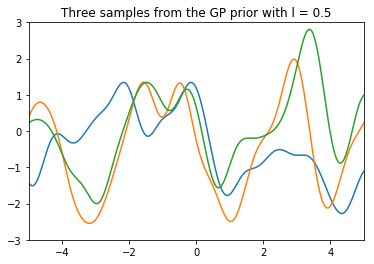

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Define the squared exponential kernel function for the covariance
#   We take the variance to be 1.
def sqr_exp_kernel(a, b, length_param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-sqdist / (2*length_param**2))

# Grid of x points
npts = 500
x_min = -5
x_max = +5
Xtest = np.linspace(x_min, x_max, npts).reshape(-1,1)   

length_param = .5  # this is "l" (correlation length)
K_ss = sqr_exp_kernel(Xtest, Xtest, length_param)

# Get Cholesky decomposition (square root) of the covariance matrix
nugget = 1e-12   # size of nugget will depend on how many points are used 
                 #  1e-12 for 500; 1e-13 for 100; 1e-15 for 50
L = np.linalg.cholesky(K_ss + nugget*np.eye(npts))

# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
# Note: mean mu = 0 here implicitly.
f_prior = np.dot(L, np.random.normal(size=(npts,3)))

# Now let's plot the 3 sampled functions.
plt.plot(Xtest, f_prior)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP prior with l = {:1.1f}'.format(length_param))
plt.show()

Now we train it on some data (see references for details):

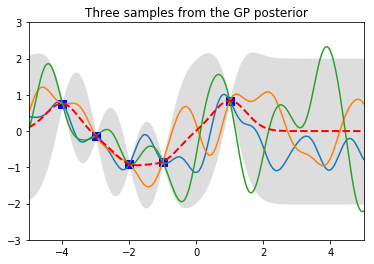

In [6]:
# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)
#ytrain = np.array([0,0,0,0,0]).reshape(5,1)

# Apply the same kernel function to our training points
nugget_train = 5e-5
K = sqr_exp_kernel(Xtrain, Xtrain, length_param)
L = np.linalg.cholesky(K + nugget_train*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = sqr_exp_kernel(Xtrain, Xtest, length_param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((npts,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)

# Draw samples from the posterior at our test points.
nugget_test = 1e-6
L = np.linalg.cholesky(K_ss + nugget_test*np.eye(npts) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(npts,3)))

plt.plot(Xtrain, ytrain, 'bs', ms=8)
plt.plot(Xtest, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP posterior')
plt.show()

### Other demos for Gaussian Processes (and other regression)

<ul>
  <li>
Gaussian process regression, where you can add data points, play with the hyperparameters, and then see the inference for the curve. It’s by Tomi Peltola:
http://www.tmpl.fi/gp/  

  <li>
This simulation shows how a GP prior is a distribution over functions, and how observing data conditions the prior to obtain the GP posterior.
http://rpradeep.webhop.net/gpr/

</ul>

<p>[Return to <a href="#Contents">Contents</a>]</p>

<hr>